# Home assignment 5 (27 pts) 
You should prepare solutions of the presented problems in this Jupyter Notebook and submit it in the Google Classroom. No links to Colab or pdf are accepted!

Please, rename the Jupyter Notebook that you will submit as ```Surname_assignment5.ipynb```, where instead of ```Surname``` you write your family name. A solution of every problem should be placed below of the corresponding problem statement.

After the running commands (Kernel -> Restart & Run All) all cells in your file have to run correctly. Please check this before submission.

## Problem 1. Nonnegative matrix factorization (17 pts) 

__1.__ Download the the code below a dataset with photos and plot any of the samples.

In [1]:
import numpy as np
import sklearn.decomposition as skdec
import sklearn.datasets as skldata
import matplotlib.pyplot as plt
import cvxpy as cp
import torch
from torch import optim

%matplotlib inline
data = skldata.fetch_olivetti_faces()


Shape of data = (400, 64, 64)


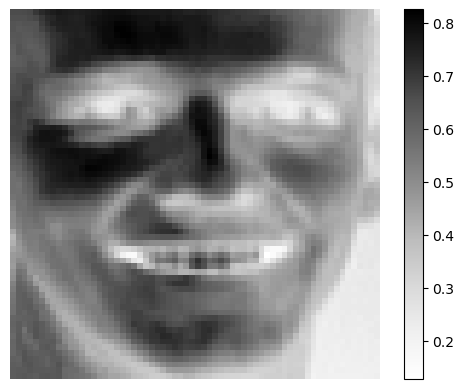

In [2]:
print("Shape of data = {}".format(data["images"].shape))
index = 42
plt.imshow(data["images"][index], cmap=plt.cm.Greys)
plt.colorbar()
_ = plt.axis("off")

__2.__ One of the classical approach to image and in general signal processing is [nonnegative matrix factorization](https://arxiv.org/pdf/1401.5226.pdf). 
Idea of the method is to solve the following optimization problem

\begin{align*}
& \min_{W, H} \frac12 \|X - WH\|^2_F \\
\text{s.t. } & W \geq 0\\
& H \geq 0,
\end{align*}

where symbol $\geq$ denotes elementwise comparison. 
Also matrices $W$ and $H$ are lowrank, i.e. $W \in \mathbb{R}^{m \times k}$ and $H \in \mathbb{R}^{k \times n}$, where $k$ is a hyper-parameter that has to be tuned.
The larger $k$, the more accurate approximation, but more time is needed to solve the problem.
The matrix $X \in \mathbb{R}^{m \times n}$, where $m$ is a number of photos in our dataset, and $n$ is a number of pixels in every picture, i.e. every row of the matrix $X$ is a vectorized image.

**Tasks**

1) (1 pts) is the above problem convex and why?

**Answer:** The problem of Nonnegative Matrix Factorization (NMF) is not convex because the objective function $\frac{1}{2} \|X - WH\|_F^2$ is not jointly convex in $W$ and $H$. While the function is convex with respect to $W$ when $H$ is fixed, and vice versa the interaction between $W$ and $H$ does not satisfy convexity conditions for both variables simultaneously.

2) (1 pts) how can you interpret factors $W$ and $H$ and why its nonnegativity is important?

**Answer:** In NMF, $W$ represents the basis matrix, where each column can be interpreted as a component or feature of the data, and $H$ is the coefficient matrix, indicating the contribution of each feature towards reconstructing the original data matrix $X$. Nonnegativity ($W \geq 0$, $H \geq 0$) is crucial as it ensures interpretability and sparsity, allowing for a parts-based representation of the data that aligns with its inherent properties.

__3.__ This problem can be approximately solved with CVXPy if the alternating optimization is used. The idea of this method is in even iterations solve the problem w.r.t $W$ while the matrix $H$ is fixed and in the odd iterations use optimal value of $W$ from the previous iteration as a fixed matrix and solve the problem w.r.t. $H$. And keep such alternating until convergence w.r.t. the changing the objective function.
Before run this method you need to initialize matrices $W$ and $H$ with some non-negative elements, probably random. The quality of the solution and running time of the method crucially depend on the initialization. So, you can test different approaches and report result of your investigation additionally.

Hint: if runtime of your experiment is too long, you can reduce the number of samples with proper pruning strategy to preserve the expected results.

**Tasks**

1) (2 pts) implement with CVXPy the alternating optimization method for this problem and solve it for some reasonable fixed $k$

2) (1 pts) plot the convergence line (objective function value vs. iteration idx) and confirm that the method converegs or the changing in objective function with iterating is very small

3) (1 pts) since the dimension of matrix $H$ is $k \times n$, then every row of $H$ can be transformed to photo in the inverse manner like they were collected in rows of matrix $X$. Plot 10-50 pictures extracted from rows of matrix $H$. What do you observe and how your observation relates to your answer the question 2) in the previous block of tasks? Use ```plt.colorbar()``` and colour scheme ```plt.cm.Greys``` for more constrast displaying the pixels

4) (1 pts) Plot matrix $W$ with functions ```plt.imshow``` or ```plt.spy``` from the ```matplotlib``` library. How much sparse is it?

## 1.1

In [3]:
num_samples = data["images"].shape[0] // 2
X_subset = data["images"][:num_samples].reshape((num_samples, -1))

m, n = X_subset.shape
k = 5  # rank for factorization
np.random.seed(42)
W = np.random.rand(m, k) 
H = np.random.rand(k, n) 

max_iters = 40 
threshold = 0.02
obj_vals = [] 


for iter in range(max_iters):
    # optimize W
    W_var = cp.Variable((m, k), nonneg=True)
    objective_W = cp.Minimize(0.5 * cp.norm(X_subset - W_var @ H, 'fro')**2)
    problem_W = cp.Problem(objective_W)
    problem_W.solve(solver=cp.SCS, verbose=True)
    W = W_var.value
    
    # optimize H
    H_var = cp.Variable((k, n), nonneg=True)
    objective_H = cp.Minimize(0.5 * cp.norm(X_subset - W @ H_var, 'fro')**2)
    problem_H = cp.Problem(objective_H)
    problem_H.solve(solver=cp.SCS, verbose=True)
    H = H_var.value

    # compute objective function value
    current_obj_val = 0.5 * np.linalg.norm(X_subset - W @ H, 'fro')**2
    obj_vals.append(current_obj_val)
    
    if iter > 0 and np.abs(obj_vals[-1] - obj_vals[-2]) < threshold:
        print(f"Converged at iteration {iter}.")
        break

  0%|          | 0/40 [00:00<?, ?it/s]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:26:26 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:26:26 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:26:26 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:26:26 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:26:26 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:26:26 PM: Compiling problem (target solver=SCS).
(CV

  2%|▎         | 1/40 [00:06<04:13,  6.49s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:26:32 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:26:32 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:26:32 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:26:32 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:26:32 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:26:32 PM: Compiling problem (target solver=SCS).
(CV

  5%|▌         | 2/40 [00:12<04:00,  6.34s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:26:38 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:26:38 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:26:38 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:26:38 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:26:38 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:26:38 PM: Compiling problem (target solver=SCS).
(CV

  8%|▊         | 3/40 [00:19<03:57,  6.41s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:26:45 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:26:45 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:26:45 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:26:45 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:26:45 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:26:45 PM: Compiling problem (target solver=SCS).
(CV

 10%|█         | 4/40 [00:26<03:59,  6.66s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:26:52 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:26:52 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:26:52 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:26:52 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:26:52 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:26:52 PM: Compiling problem (target solver=SCS).
(CV

 12%|█▎        | 5/40 [00:33<03:59,  6.84s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:26:59 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:26:59 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:26:59 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:26:59 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:26:59 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:26:59 PM: Compiling problem (target solver=SCS).
(CV

 15%|█▌        | 6/40 [00:43<04:33,  8.03s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:27:09 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:27:09 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:27:09 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:27:09 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:27:09 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:27:09 PM: Compiling problem (target solver=SCS).
(CV

 18%|█▊        | 7/40 [00:54<04:50,  8.81s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:27:20 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:27:20 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:27:20 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:27:20 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:27:20 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:27:20 PM: Compiling problem (target solver=SCS).
(CV

 20%|██        | 8/40 [01:04<04:58,  9.33s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:27:30 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:27:30 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:27:30 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:27:30 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:27:30 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:27:30 PM: Compiling problem (target solver=SCS).
(CV

 22%|██▎       | 9/40 [01:15<05:01,  9.72s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:27:41 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:27:41 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:27:41 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:27:41 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:27:41 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:27:41 PM: Compiling problem (target solver=SCS).
(CV

 25%|██▌       | 10/40 [01:25<04:59,  9.98s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:27:51 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:27:51 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:27:51 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:27:51 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:27:51 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:27:51 PM: Compiling problem (target solver=SCS).
(CV

 28%|██▊       | 11/40 [01:36<04:54, 10.15s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:28:02 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:28:02 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:28:02 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:28:02 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:28:02 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:28:02 PM: Compiling problem (target solver=SCS).
(CV

 30%|███       | 12/40 [01:46<04:48, 10.30s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:28:12 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:28:12 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:28:12 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:28:12 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:28:12 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:28:13 PM: Compiling problem (target solver=SCS).
(CV

 32%|███▎      | 13/40 [01:57<04:42, 10.47s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:28:23 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:28:23 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:28:23 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:28:23 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:28:23 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:28:23 PM: Compiling problem (target solver=SCS).
(CV

 35%|███▌      | 14/40 [02:09<04:45, 10.96s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:28:35 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:28:35 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:28:35 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:28:35 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:28:35 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:28:35 PM: Compiling problem (target solver=SCS).
(CV

 38%|███▊      | 15/40 [02:22<04:47, 11.49s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:28:48 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:28:48 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:28:48 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:28:48 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:28:48 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:28:48 PM: Compiling problem (target solver=SCS).
(CV

 40%|████      | 16/40 [02:33<04:32, 11.35s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:28:59 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:28:59 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:28:59 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:28:59 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:28:59 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:28:59 PM: Compiling problem (target solver=SCS).
(CV

 42%|████▎     | 17/40 [02:44<04:19, 11.29s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:29:10 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:29:10 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:29:10 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:29:10 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:29:10 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:29:10 PM: Compiling problem (target solver=SCS).
(CV

 45%|████▌     | 18/40 [02:55<04:07, 11.24s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:29:21 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:29:21 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:29:21 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:29:21 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:29:22 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:29:22 PM: Compiling problem (target solver=SCS).
(CV

 48%|████▊     | 19/40 [03:07<03:55, 11.23s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:29:33 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:29:33 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:29:33 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:29:33 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:29:33 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:29:33 PM: Compiling problem (target solver=SCS).
(CV

 50%|█████     | 20/40 [03:18<03:45, 11.27s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:29:44 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:29:44 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:29:44 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:29:44 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:29:44 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:29:44 PM: Compiling problem (target solver=SCS).
(CV

 52%|█████▎    | 21/40 [03:30<03:35, 11.36s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:29:56 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:29:56 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:29:56 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:29:56 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:29:56 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:29:56 PM: Compiling problem (target solver=SCS).
(CV

 55%|█████▌    | 22/40 [03:41<03:24, 11.39s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:30:07 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:30:07 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:30:07 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:30:07 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:30:07 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:30:07 PM: Compiling problem (target solver=SCS).
(CV

 57%|█████▊    | 23/40 [03:52<03:13, 11.38s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:30:18 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:30:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:30:18 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:30:18 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:30:18 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:30:18 PM: Compiling problem (target solver=SCS).
(CV

 60%|██████    | 24/40 [04:04<03:01, 11.36s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:30:30 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:30:30 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:30:30 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:30:30 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:30:30 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:30:30 PM: Compiling problem (target solver=SCS).
(CV

 62%|██████▎   | 25/40 [04:15<02:49, 11.30s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:30:41 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:30:41 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:30:41 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:30:41 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:30:41 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:30:41 PM: Compiling problem (target solver=SCS).
(CV

 65%|██████▌   | 26/40 [04:26<02:37, 11.26s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:30:52 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:30:52 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:30:52 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:30:52 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:30:52 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:30:52 PM: Compiling problem (target solver=SCS).
(CV

 68%|██████▊   | 27/40 [04:37<02:26, 11.27s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:31:03 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:31:03 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:31:03 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:31:03 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:31:03 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:31:03 PM: Compiling problem (target solver=SCS).
(CV

 70%|███████   | 28/40 [04:48<02:14, 11.22s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:31:14 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:31:14 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:31:14 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:31:14 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:31:15 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:31:15 PM: Compiling problem (target solver=SCS).
(CV

 72%|███████▎  | 29/40 [05:00<02:03, 11.21s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:31:26 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:31:26 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:31:26 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:31:26 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:31:26 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:31:26 PM: Compiling problem (target solver=SCS).
(CV

 75%|███████▌  | 30/40 [05:11<01:52, 11.20s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:31:37 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:31:37 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:31:37 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:31:37 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:31:37 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:31:37 PM: Compiling problem (target solver=SCS).
(CV

 78%|███████▊  | 31/40 [05:22<01:40, 11.18s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:31:48 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:31:48 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:31:48 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:31:48 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:31:48 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:31:48 PM: Compiling problem (target solver=SCS).
(CV

 80%|████████  | 32/40 [05:34<01:32, 11.58s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:32:00 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:32:00 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:32:00 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:32:00 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:32:00 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:32:01 PM: Compiling problem (target solver=SCS).
(CV

 82%|████████▎ | 33/40 [05:47<01:23, 11.88s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:32:13 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:32:13 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:32:13 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:32:13 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:32:13 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:32:13 PM: Compiling problem (target solver=SCS).
(CV

 85%|████████▌ | 34/40 [05:59<01:12, 12.07s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:32:26 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:32:26 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:32:26 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:32:26 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:32:26 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:32:26 PM: Compiling problem (target solver=SCS).
(CV

 88%|████████▊ | 35/40 [06:12<01:01, 12.32s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:32:38 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:32:38 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:32:38 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:32:38 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:32:38 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:32:38 PM: Compiling problem (target solver=SCS).
(CV

 90%|█████████ | 36/40 [06:25<00:49, 12.48s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:32:51 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:32:51 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:32:51 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:32:51 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:32:51 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:32:51 PM: Compiling problem (target solver=SCS).
(CV

 92%|█████████▎| 37/40 [06:38<00:37, 12.60s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:33:04 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:33:04 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:33:04 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:33:04 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:33:04 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:33:04 PM: Compiling problem (target solver=SCS).
(CV

 95%|█████████▌| 38/40 [06:51<00:25, 12.68s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:33:17 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:33:17 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:33:17 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:33:17 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:33:17 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:33:17 PM: Compiling problem (target solver=SCS).
(CV

 98%|█████████▊| 39/40 [07:04<00:12, 12.75s/it]

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Feb 04 07:33:30 PM: Your problem has 1000 variables, 0 constraints, and 0 parameters.
(CVXPY) Feb 04 07:33:30 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 04 07:33:30 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 04 07:33:30 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 04 07:33:30 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Feb 04 07:33:30 PM: Compiling problem (target solver=SCS).
(CV

100%|██████████| 40/40 [07:17<00:00, 10.93s/it]


## 1.2

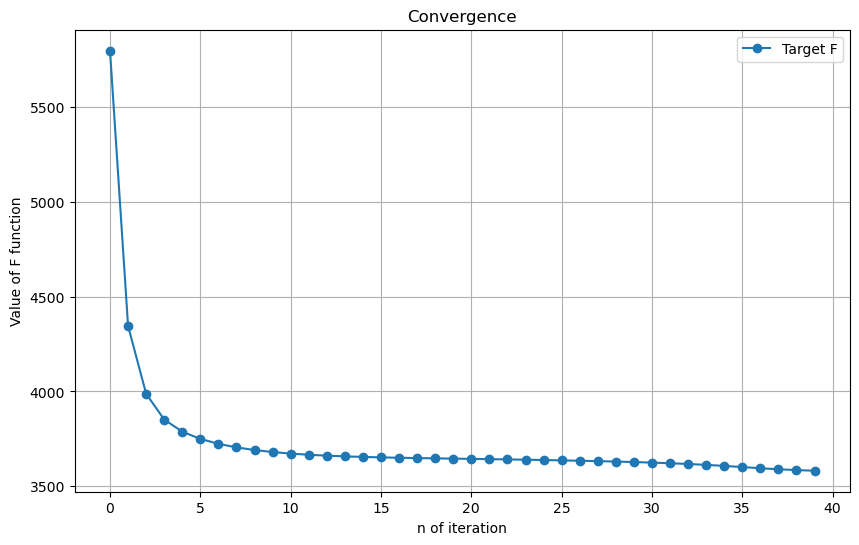

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(obj_vals, '-o', label='Target F')
plt.xlabel('n of iteration')
plt.ylabel('Value of F function')
plt.title('Convergence')
plt.legend()
plt.grid(True)
plt.show()

## 1.3

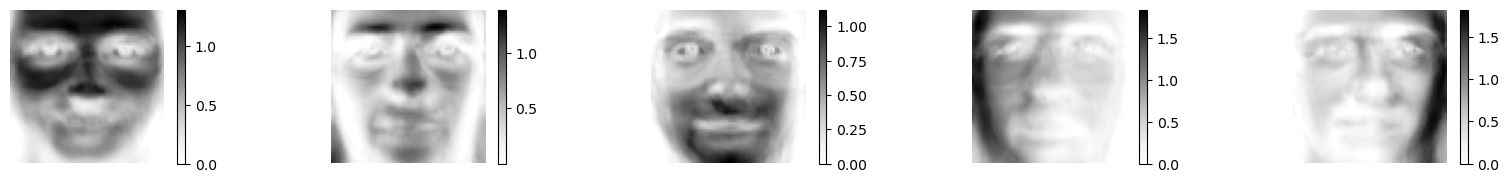

In [5]:
num_images = 5 
image_shape = (64, 64) 

fig, axes = plt.subplots(1, num_images, figsize=(20, 2))
for i, ax in enumerate(axes):
    img = H[i].reshape(image_shape)
    ax.imshow(img, cmap=plt.cm.Greys, interpolation='nearest')
    ax.axis('off')
    plt.colorbar(ax.imshow(img, cmap=plt.cm.Greys), ax=ax)
plt.show()


## 1.4

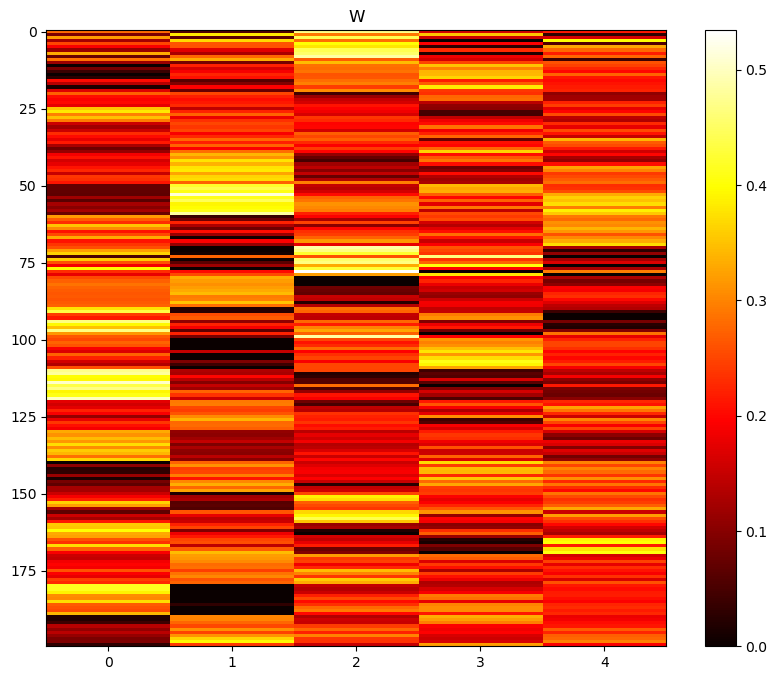

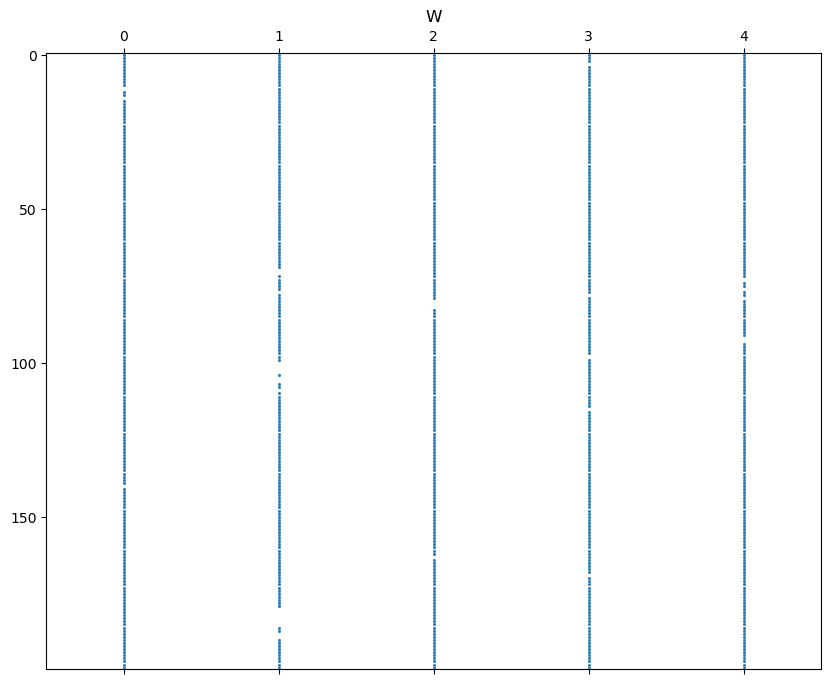

In [6]:
plt.figure(figsize=(10, 8))
plt.imshow(W, aspect='auto', cmap='hot')
plt.colorbar()
plt.title('W')
plt.show()

plt.figure(figsize=(10, 8))
plt.spy(W, markersize=1, aspect='auto')
plt.title('W')
plt.show()


## Solving NMF with stochastic gradient methods (10 pts)

Note that the objective function in the NMF problem can be decomposed in the form

$$ \sum_{ij} f_{ij}(w) \to \min_w, $$ 

where $w$ represents the stacked target variables $W$ and $H$ and tuple $(i, j)$ indicates the value of the original matrix that is approximated.
Therefore, we can estimate the gradient of such objective and use methods based on the stochastic gradient estimation. You can enforce the nonnegativity constraints with direct projection of the updated varibles like 

$$ w_k := clip(w_k, 0, +\infty), $$

i.e. all negative values become zero and positive values remain the same.
You can use PyTorch or Optax in this task.

- (5 pts) Compare convergence of SGD, Momentum SGD and Adam optimizers in solving this problem. Test three different learning rates and do your best to get convergence at least for two of them.
- (3 pts) Test different batch sizes and study how they affect the convergence robustness and the feasible range of learning rates 
- (2 pts) what optimizer (ALS or any from then listed in this task) gives better solution and how is it fast? Try to explain your observations.

In [9]:
X_tensor = torch.from_numpy(X_subset).float()

m, n = X_tensor.shape
k = 25
learning_rates = [1e-3, 1e-4, 1e-5] 

W = torch.rand(m, k, requires_grad=True)
H = torch.rand(k, n, requires_grad=True)

def loss_fn(X, W, H):
    return torch.norm(X - torch.matmul(W, H), p='fro') ** 2

for lr in learning_rates:
    for optimizer_name in ['SGD', 'MomentumSGD', 'Adam']:
        if optimizer_name == 'SGD':
            optimizer = optim.SGD([W, H], lr=lr)
        elif optimizer_name == 'MomentumSGD':
            optimizer = optim.SGD([W, H], lr=lr, momentum=0.9)
        elif optimizer_name == 'Adam':
            optimizer = optim.Adam([W, H], lr=lr)

        for epoch in range(1000):
            optimizer.zero_grad()
            loss = loss_fn(X_tensor, W, H)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                W.clamp_(0)
                H.clamp_(0)
            
            if epoch % 100 == 0:
                print(f"Optimizer: {optimizer_name}, LR: {lr}, Epoch: {epoch}, Loss: {loss.item()}")

        W.grad.zero_()
        H.grad.zero_()


Optimizer: SGD, LR: 0.001, Epoch: 0, Loss: 26809160.0
Optimizer: SGD, LR: 0.001, Epoch: 100, Loss: 21764.087890625
Optimizer: SGD, LR: 0.001, Epoch: 200, Loss: 18264.435546875
Optimizer: SGD, LR: 0.001, Epoch: 300, Loss: 17224.53125
Optimizer: SGD, LR: 0.001, Epoch: 400, Loss: 16873.572265625
Optimizer: SGD, LR: 0.001, Epoch: 500, Loss: 16735.802734375
Optimizer: SGD, LR: 0.001, Epoch: 600, Loss: 16670.408203125
Optimizer: SGD, LR: 0.001, Epoch: 700, Loss: 16633.568359375
Optimizer: SGD, LR: 0.001, Epoch: 800, Loss: 16609.080078125
Optimizer: SGD, LR: 0.001, Epoch: 900, Loss: 16591.375
Optimizer: MomentumSGD, LR: 0.001, Epoch: 0, Loss: 16577.34375
Optimizer: MomentumSGD, LR: 0.001, Epoch: 100, Loss: 2985.174072265625
Optimizer: MomentumSGD, LR: 0.001, Epoch: 200, Loss: 2959.376708984375
Optimizer: MomentumSGD, LR: 0.001, Epoch: 300, Loss: 2944.90380859375
Optimizer: MomentumSGD, LR: 0.001, Epoch: 400, Loss: 2934.8388671875
Optimizer: MomentumSGD, LR: 0.001, Epoch: 500, Loss: 2926.61743

In [13]:
X_tensor.shape

torch.Size([200, 4096])

In [18]:
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(X_tensor)
batch_sizes = [200, 400, 800]

def train_model(batch_size, lr):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    W = torch.rand(m, k, requires_grad=True)
    H = torch.rand(k, n, requires_grad=True)
    optimizer = optim.Adam([W, H], lr=lr)
    
    for epoch in range(100):
        for X_batch, in dataloader:
            optimizer.zero_grad()
            loss = loss_fn(X_batch, W, H)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                W.clamp_(0)
                H.clamp_(0)

        if epoch % 10 == 0:
            print(f"Batch Size: {batch_size}, Epoch: {epoch}, Loss: {loss.item()}")

for batch_size in batch_sizes:
    train_model(batch_size, lr=1e-4)


Batch Size: 200, Epoch: 0, Loss: 27952492.0
Batch Size: 200, Epoch: 10, Loss: 27717566.0
Batch Size: 200, Epoch: 20, Loss: 27479910.0
Batch Size: 200, Epoch: 30, Loss: 27242926.0
Batch Size: 200, Epoch: 40, Loss: 27021626.0
Batch Size: 200, Epoch: 50, Loss: 26790562.0
Batch Size: 200, Epoch: 60, Loss: 26560586.0
Batch Size: 200, Epoch: 70, Loss: 26330418.0
Batch Size: 200, Epoch: 80, Loss: 26106072.0
Batch Size: 200, Epoch: 90, Loss: 25884550.0
Batch Size: 400, Epoch: 0, Loss: 27231860.0
Batch Size: 400, Epoch: 10, Loss: 27001034.0
Batch Size: 400, Epoch: 20, Loss: 26764214.0
Batch Size: 400, Epoch: 30, Loss: 26531216.0
Batch Size: 400, Epoch: 40, Loss: 26305550.0
Batch Size: 400, Epoch: 50, Loss: 26080596.0
Batch Size: 400, Epoch: 60, Loss: 25857538.0
Batch Size: 400, Epoch: 70, Loss: 25641144.0
Batch Size: 400, Epoch: 80, Loss: 25417194.0
Batch Size: 400, Epoch: 90, Loss: 25204450.0
Batch Size: 800, Epoch: 0, Loss: 27521100.0
Batch Size: 800, Epoch: 10, Loss: 27292518.0
Batch Size: 8

Smaller batches have better convergence, but larger batches have more "stable" loss increment.

## Problem 2: Fitting point to sphere (10 pts)

Assume you have a set of points in the plane and you know that they belong to a sphere up to the additive noise. Your task is 
- (2 pts) to state the convex optimization problem to find the center and the radius of the best fitted sphere
- (3 pts) proof that the stated problem is convex 
- (4 pts) solve this problem analytically.

After that compare your analytical solution with one given by CVXPy. 

- (1 pts) Show that the optimal objectives for these two approaches are very close up to machine precision. 

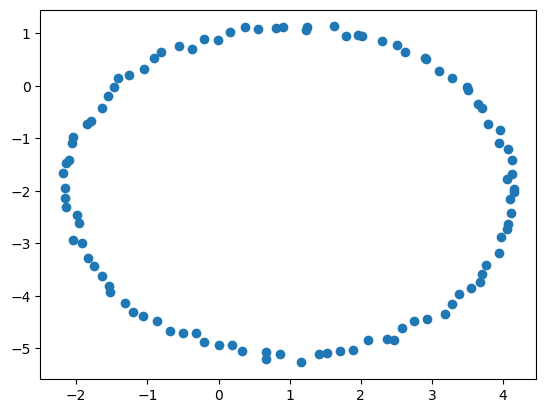

In [24]:
import numpy as np
import matplotlib.pyplot as plt
n = 2
num_samples = 100
true_center = np.array([1, -2])
true_radius = np.pi
phi = np.linspace(0, 2*np.pi, num=num_samples)
X = np.vstack((true_center[0] + true_radius * np.cos(phi), true_center[1] + true_radius *np.sin(phi))) + 0.05 * np.random.randn(2, num_samples)
plt.scatter(X[0, :], X[1, :])

## 2.1

The problem can be formulated as follows:

- $ \text{minimize} \quad f(c, r) = \sum_{i=1}^{n} ( \|x_i - c\|_2 - r )^2 $
- $ \text{subject to} \quad r \geq 0 $